### look at the wavelength dependence of flux and slit position

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii, fits
from matplotlib.gridspec import GridSpec
from scipy import interpolate
from astropy.visualization import MinMaxInterval, AsinhStretch, HistEqStretch, ImageNormalize
from scipy.optimize import curve_fit
#%matplotlib inline
%matplotlib ipympl

In [2]:
# load atmospheric transmission file
path = '/Users/jpw/idl/Spextool/data/'
file = 'atran75000'
hdu = fits.open(path+file+'.fits')
tdata = hdu[0].data
atrans = interpolate.interp1d(tdata[0,:], tdata[1,:])
hdu.close()

In [3]:
# specify the rectified image and associated wavecal file
path = '../191008/'
#source = 'rectified1-2'
source = 'combined'
calfile = 'wavecal1-28'

hdu1 = fits.open(path+'proc/'+source+'.fits')
flux = hdu1[0].data
var = hdu1[1].data
rect_hd = hdu1[0].header
#flux_norm = ImageNormalize(flux, interval=MinMaxInterval(), stretch=HistEqStretch(flux))
flux_norm = ImageNormalize(flux, vmin=-5, vmax=5, stretch=AsinhStretch(0.3))

hdu2 = fits.open(path+'cal/'+calfile+'.fits')
wc_hd = hdu2[0].header
orders = wc_hd['ORDERS'].split(',')
norders = wc_hd['NORDERS']

In [4]:
j1 = 30           # starting point of first order -- figured out by hand
dj_AB = 121       # width of each order -- this should match the size of the number of rows in the order extension
dj_blank = 30     # gap between orders -- this is figured out by eye and assumed to be the same for all orders

Order = 110, Min/Max wavelength = 4.672616134581073, 4.712122593827319


Text(0, 0.5, "Slit offset ('')")

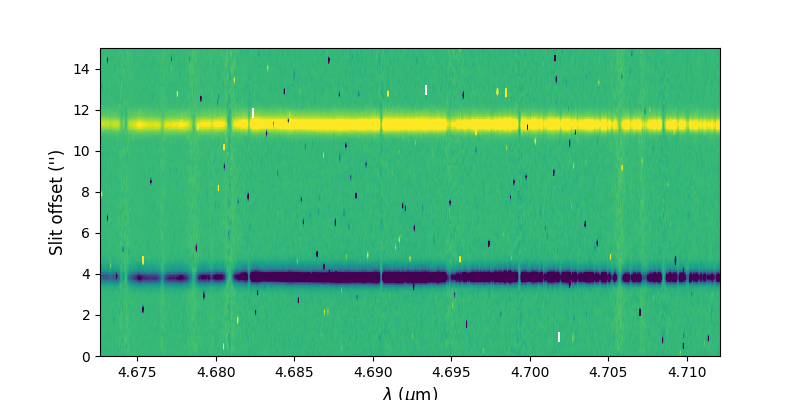

In [5]:
# just do one order for now
order = 110
norder = orders.index(str(order))

j0 = j1 + (dj_AB + dj_blank) * norder
order_flux = flux[j0:j0+dj_AB, :]
order_var = var[j0:j0+dj_AB, :]

wavecal = hdu2[3+norder].data
wl = wavecal[0, 0, 1:]
slitpos = wavecal[0, 1:, 0]
print(f'Order = {order}, Min/Max wavelength = {wl.min()}, {wl.max()}')
extent = [wl.min(), wl.max(), slitpos.min(), slitpos.max()]

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(order_flux, origin='lower', norm=flux_norm, extent=extent, aspect='auto')
ax.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=12)
ax.set_ylabel(r"Slit offset ('')", fontsize=12)

In [6]:
# two gaussians with different peaks and offsets but same FWHM
def gauss2(x, A1, x1, A2, x2, sigma):
    y = A1 * np.exp(-0.5*((x-x1)/sigma)**2) + A2 * np.exp(-0.5*((x-x2)/sigma)**2)
    return y

In [7]:
def checkfit(pfit, perr, pfit_median, verbose=False):
    # check a few heuristics to see if this is a reasonable fit
    A1 = -pfit[0]
    x1 = pfit[1]
    A2 = pfit[2]
    x2 = pfit[3]
    sig = pfit[4]
    ok = True
    if (np.abs(A1-A2)/(A1+A2) > 0.2):
        if verbose: print('*** Positive and negative amplitudes are too different')
        ok = False
    if perr[1] > 0.05:
        if verbose: print('*** Error in negative position is too large')
        ok = False
    if perr[3] > 0.05:
        if verbose: print('*** Error in positive position is too large')
        ok = False
    if (perr[4] > 0.1*pfit_median[4]):
        if verbose: print('*** Error in sigma is too large')
        ok = False
    if (np.abs(x1-pfit_median[1]) > 1):
        if verbose: print('*** Negative position is too different from median')
        ok = False
    if (np.abs(x2-pfit_median[3]) > 1):
        if verbose: print('*** Positive position is too different from median')
        ok = False
    return ok

[-7.55112282  3.8124593   7.38924262 11.31723491  0.22758415]
[0.10340904 0.00393384 0.10296188 0.00402002 0.00281162]


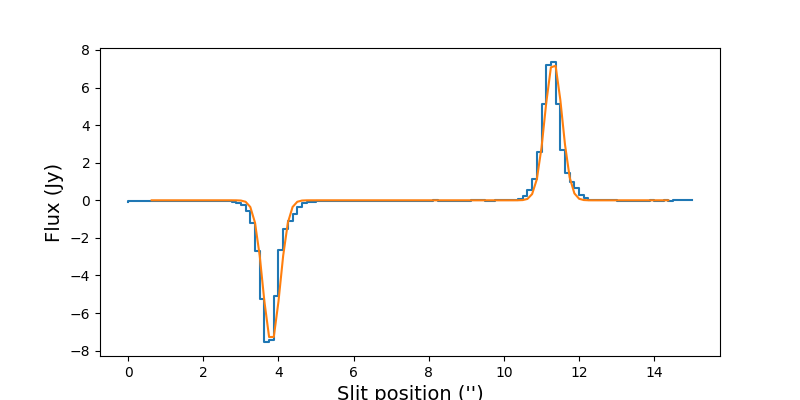

In [8]:
# stack in wavelength to get the average slit profile to guide individual fits
im_median = np.nanmedian(order_flux, axis=1)
p0 = [np.min(im_median), slitpos[np.argmin(im_median)], np.max(im_median), slitpos[np.argmax(im_median)], 1]

# don't fit within s_nofit of the edges
s_nofit = 0.5
fit_range = (slitpos > s_nofit) & (slitpos < slitpos.max()-s_nofit)

# fit two gaussians to the data
xfit = slitpos[fit_range]
pfit_median, pcov = curve_fit(gauss2, xfit, im_median[fit_range], p0)
perr = np.sqrt(np.diag(pcov))
yfit = gauss2(xfit, *pfit_median)

fig, ax = plt.subplots(figsize=(8, 4))
ax.step(slitpos, im_median)
ax.plot(xfit, yfit)
ax.set_xlabel(r"Slit position ('')", fontsize=14)
ax.set_ylabel(r"Flux (Jy)", fontsize=14)

print(pfit_median)
print(perr)

[-9.67421829  3.801718    9.72337499 11.31982408  0.2291515 ]
[0.17520658 0.0052522  0.17538423 0.00522565 0.00370444]


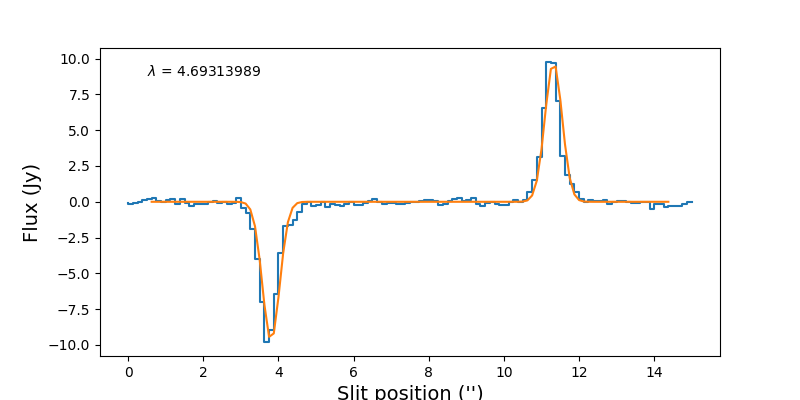

In [9]:
# plot the profile for a single column
ncol = 1000
wl1 = wl[ncol]
flux_slice = order_flux[:, ncol]
var_slice = order_var[:, ncol]

p0 = [np.min(flux_slice), pfit_median[1], np.max(flux_slice), pfit_median[3], pfit_median[4]]
pfit, pcov = curve_fit(gauss2, xfit, flux_slice[fit_range], p0)#, sigma=1/var_slice[fit_range])
perr = np.sqrt(np.diag(pcov))
yfit = gauss2(xfit, *pfit)

fig, ax = plt.subplots(figsize=(8, 4))
ax.step(slitpos, flux_slice)
ax.text(0.5, 0.9*np.max(flux_slice), f'$\lambda$ = {wl1:10.8f}')
ax.plot(xfit, yfit)
ax.set_xlabel(r"Slit position ('')", fontsize=14)
ax.set_ylabel(r"Flux (Jy)", fontsize=14)

print(pfit)
print(perr)
if not checkfit(pfit, perr, pfit_median, verbose=True): print('*** bad fit')


In [10]:
# now go through the entire wavelength range
# integrate over an aperture on the positive and negative side
# fit a double gaussian and calculate the peak slit position

# tell me about fitting errors
verbose = False

imfit = np.zeros(order_flux.shape)
nwl = wl.size
spectrum = np.zeros((4, nwl)) + np.nan
SA  = np.zeros((4, nwl)) + np.nan

# aperture for calculating the spectrum; +/- 3sigma of the median peak
sneg1 = pfit_median[1] - 3 * pfit_median[4]
sneg2 = pfit_median[1] + 3 * pfit_median[4]
spos1 = pfit_median[3] - 3 * pfit_median[4]
spos2 = pfit_median[3] + 3 * pfit_median[4]

ineg1 = np.argmin(np.abs(slitpos - sneg1))
ineg2 = np.argmin(np.abs(slitpos - sneg2))
ipos1 = np.argmin(np.abs(slitpos - spos1))
ipos2 = np.argmin(np.abs(slitpos - spos2))

for n in range(wl.size):
    flux_slice = order_flux[:, n]
    weights = 1 / order_var[:, n]
    spectrum[0, n] = np.sum(weights[ineg1:ineg2]*flux_slice[ineg1:ineg2]) / np.sum(weights[ineg1:ineg2])
    spectrum[1, n] = np.sum(weights[ipos1:ipos2]*flux_slice[ipos1:ipos2]) / np.sum(weights[ipos1:ipos2])
    spectrum[2, n] = 1 / np.sum(weights[ineg1:ineg2])
    spectrum[3, n] = 1 / np.sum(weights[ipos1:ipos2])
    p0 = [np.min(flux_slice), pfit_median[1], np.max(flux_slice), pfit_median[3], pfit_median[4]]
    try:
        pfit, pcov = curve_fit(gauss2, xfit, flux_slice[fit_range], p0)
        perr = np.sqrt(np.diag(pcov))
        if checkfit(pfit, perr, pfit_median, verbose=verbose):
            imfit[:, n] = gauss2(slitpos, *pfit)
            SA[0, n] = pfit[1]
            SA[1, n] = pfit[3]
            SA[2, n] = perr[1]
            SA[3, n] = perr[3]
        else:
            if verbose: print(wl[n])
    except RuntimeError:
        pass
    except ValueError:
        pass

/Users/jpw/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [11]:
# flags for data quality, note high snr needed for SA
flag1 = atrans(wl) < 0.5
flag2 = -spectrum[0, :] / spectrum[2, :] < 100
flag3 = spectrum[1, :] / spectrum[3, :] < 100
bad = [np.any([flag1[i], flag2[i], flag3[i]]) for i in range(len(flag1))]
SA[:, bad] = np.nan

Text(0, 0.5, "Slit offset ('')")

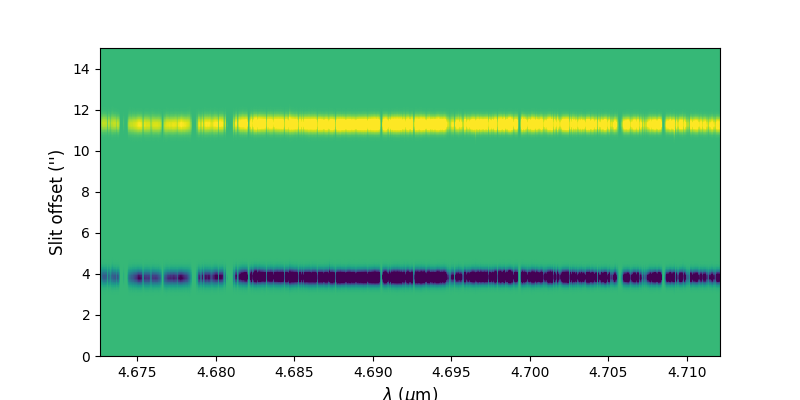

In [12]:
# plot the fit image to compare to the data
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(imfit, origin='lower', norm=flux_norm, extent=extent, aspect='auto')
ax.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=12)
ax.set_ylabel(r"Slit offset ('')", fontsize=12)

Text(0, 0.5, "Slit offset ('')")

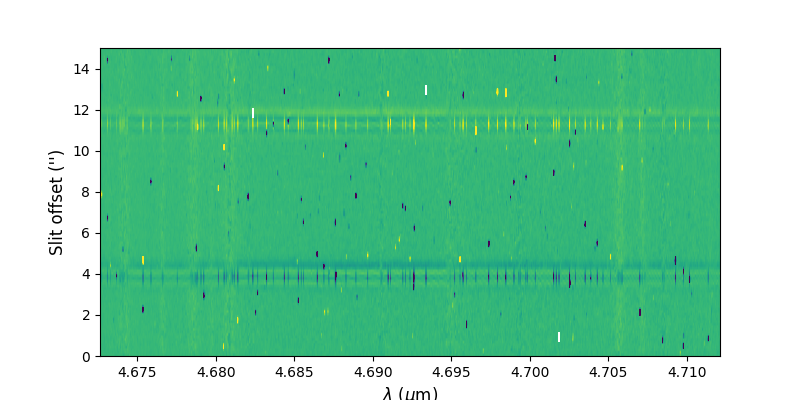

In [13]:
# check the residuals - these are quite low level, reflecting non-gaussian profiles rather than poor fit
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(order_flux-imfit, origin='lower', norm=flux_norm, extent=extent, aspect='auto')
ax.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=12)
ax.set_ylabel(r"Slit offset ('')", fontsize=12)

Text(0, 0.5, 'Flux (Jy)')

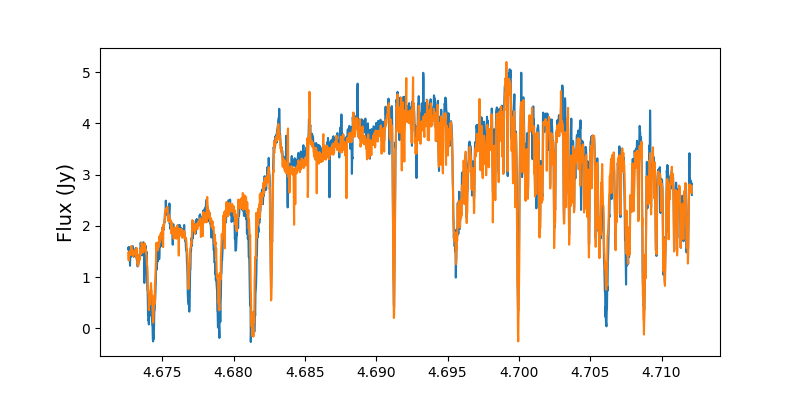

In [14]:
# plot the spectrum - not yet divided by the standard
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(wl, -spectrum[0, :])
ax.plot(wl, spectrum[1, :])
ax.set_ylabel(r"$\lambda$ ($\mu$m)", fontsize=14)
ax.set_ylabel(r"Flux (Jy)", fontsize=14)

Text(0, 0.5, "Slit position ('')")

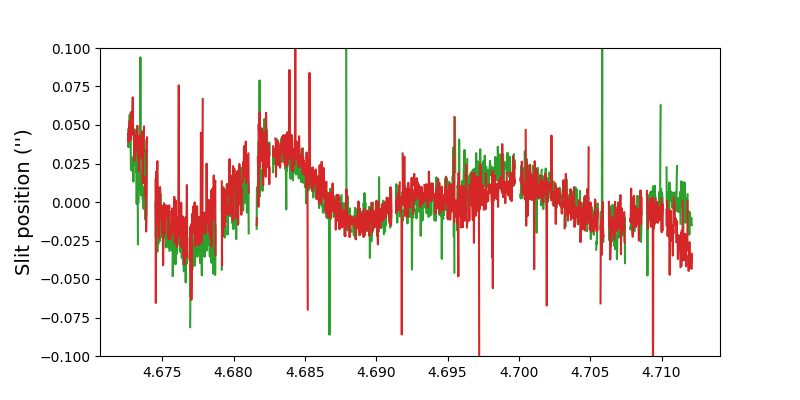

In [15]:
# plot the SA signal
fig, ax = plt.subplots(figsize=(8, 4))

# absolute positions on the slit
ax.plot(wl, SA[0, :])
ax.plot(wl, SA[1, :])
ax.set_ylim(0,15)

# take away their median to show overlap
SA[0, :] -= np.nanmedian(SA[0, :])
SA[1, :] -= np.nanmedian(SA[1, :])
ax.plot(wl, SA[0, :])
ax.plot(wl, SA[1, :])
ax.set_ylim(-0.1, 0.1)
ax.set_ylabel(r"$\lambda$ ($\mu$m)", fontsize=14)
ax.set_ylabel(r"Slit position ('')", fontsize=14)

Text(0, 0.5, "Slit position ('')")

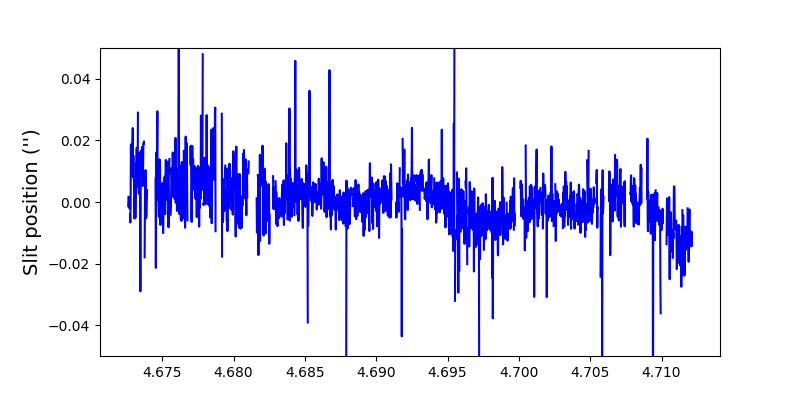

In [16]:
# plot the combined SA signal
SA_comb = 0.5 * (SA[1, :] - SA[0, :])
SA_comb_err = 0.5 * np.sqrt(SA[3, :]**2 + SA[2, :]**2)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(wl, SA_comb, color='b')
#ax.errorbar(wl, SA_comb, yerr=SA_comb_err, color='b', ecolor='r', barsabove=True)
ax.set_ylim(-0.05,0.05)
ax.set_ylabel(r"$\lambda$ ($\mu$m)", fontsize=14)
ax.set_ylabel(r"Slit position ('')", fontsize=14)

#axr = ax.twinx()
#axr.plot(wl, 100*atrans(wl), '-', color='gray', alpha=0.5)
#axr.set_ylabel(r'Transmission (%)', fontsize=14)
#axr.set_ylim(-400,100)
#axr.set_yticks([-400,-300,-200,-100,0,100])
#axr.set_yticklabels(['','','','','0','100'])